1/1 [==============================] - 0s 47ms/step
Prediction for frame: 0.08046907931566238
1/1 [==============================] - 0s 25ms/step
Prediction for frame: 0.07134068757295609
1/1 [==============================] - 0s 35ms/step
Prediction for frame: 0.10542332381010056
1/1 [==============================] - 0s 20ms/step
Prediction for frame: 0.10533119738101959
1/1 [==============================] - 0s 14ms/step
Prediction for frame: 0.161454439163208
1/1 [==============================] - 0s 22ms/step
Prediction for frame: 0.13029694557189941
1/1 [==============================] - 0s 15ms/step
Prediction for frame: 0.1525687575340271
1/1 [==============================] - 0s 29ms/step
Prediction for frame: 0.15798455476760864
1/1 [==============================] - 0s 34ms/step
Prediction for frame: 0.20079033076763153
1/1 [==============================] - 0s 13ms/step
Prediction for frame: 0.20923276245594025
Уровень усталости: Низкий, Оценка: 0.1374892145395279


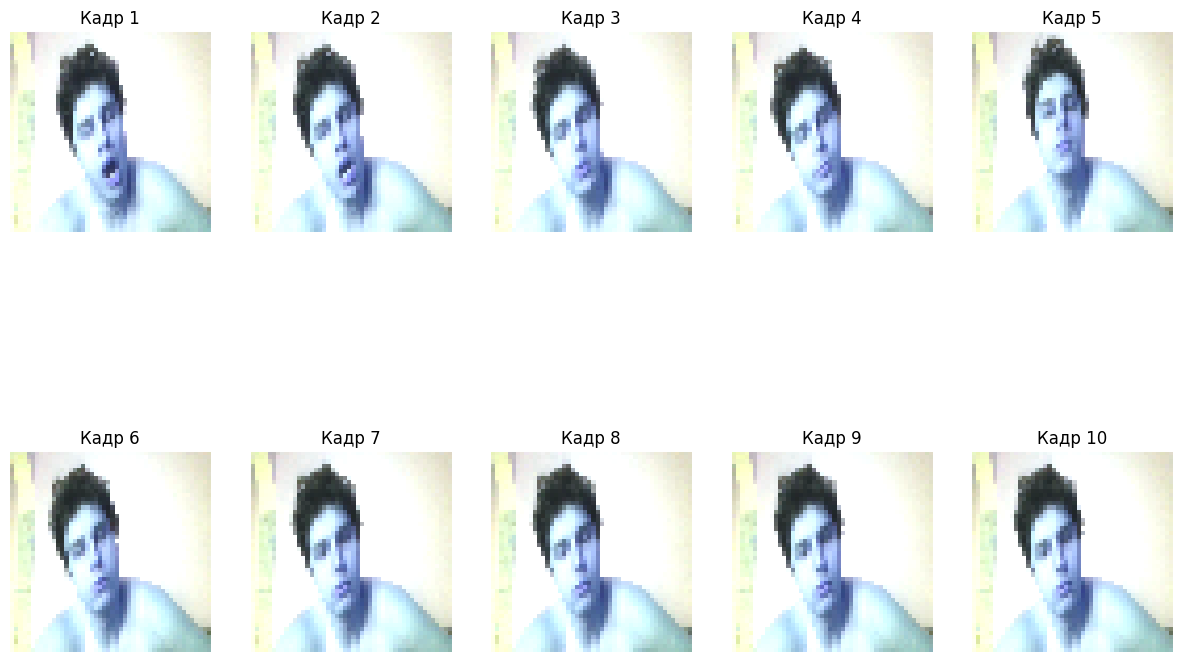

In [5]:
import time
import numpy as np
import os
import tensorflow as tf
import cv2
from datetime import datetime
import matplotlib.pyplot as plt


# Загрузка модели
model = tf.keras.models.load_model(os.path.join('..', 'neural_network', 'data', 'models', 'fatigue_model.keras'))

# Функция для извлечения кадров из видео
def extract_frames(video_path, num_frames=10, target_size=(48, 48)):
    """
    Извлекает кадры из видео.
    :param video_path: Путь к видеофайлу.
    :param num_frames: Количество кадров для извлечения.
    :param target_size: Размер кадров (высота, ширина).
    :return: Массив кадров.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            # Применяем фильтры для улучшения качества
            frame = cv2.GaussianBlur(frame, (5, 5), 0)
            alpha = 1.5  # Контраст
            beta = 30    # Яркость
            frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
            frame = cv2.resize(frame, target_size)
            frame = frame / 255.0  # Нормализация
            frames.append(frame)
    cap.release()
    return np.array(frames)

# Функция для анализа видео
def analyze_video(video_path, num_frames=10):
    """
    Анализирует видео на наличие усталости.
    :param video_path: Путь к видеофайлу.
    :param num_frames: Количество кадров для анализа.
    :return: Уровень усталости (от 0 до 1).
    """
    # Извлечение кадров
    frames = extract_frames(video_path, num_frames)
    
    # Предсказание для каждого кадра
    predictions = []
    for frame in frames:
        frame = np.expand_dims(frame, axis=0)  # Добавляем batch dimension
        prediction = model.predict(frame)
        print(f"Prediction for frame: {prediction[0][0]}") 
        predictions.append(prediction[0][0])
    
    # Агрегация результатов (среднее значение)
    fatigue_level = np.mean(predictions)
    if fatigue_level < 0.01:
        fatigue_level = round(fatigue_level * 100, 1)
    elif fatigue_level < 0.1:
        fatigue_level = round(fatigue_level * 10, 1)
        
    fatigue_level_string = "Высокий" if fatigue_level > 0.5 else "Низкий"
    return fatigue_level_string, fatigue_level

# Пример использования
video_path = 'data/video/test2.mp4'
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Ошибка: Не удалось открыть камеру.")
    exit()

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

#time.sleep(5)  
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('temp_video.avi', fourcc, 30.0, (1280, 720))

# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 720)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

start_time = datetime.now()
# time.sleep(15) 
while (datetime.now() - start_time).seconds < 10:  # Запись 10 секунд
    ret, frame = cap.read()
    if ret:
        out.write(frame)
    else:
        break

cap.release()
out.release()

# Анализ видео
level, score = analyze_video('temp_video.avi', 10)
print(f"Уровень усталости: {level}, Оценка: {score}")
# Визуализация кадров
frames = extract_frames('temp_video.avi', num_frames=10)
plt.figure(figsize=(15, 10))
for i, frame in enumerate(frames):
    plt.subplot(2, 5, i + 1)
    plt.imshow(frame)
    plt.title(f"Кадр {i + 1}")
    plt.axis('off')
plt.show()


In [4]:
import tensorflow as tf
import numpy as np
import os

# Загрузка модели
model = tf.keras.models.load_model(os.path.join('..', 'neural_network', 'data', 'models', 'fatigue_model.keras'))

# Функция для предсказания усталости
def predict_fatigue(image_path):
    # Загрузка и предобработка изображения
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(48, 48))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность батча
    img_array /= 255.0  # Нормализация

    # Предсказание
    prediction = model.predict(img_array)
    fatigue_level = "Высокий" if prediction[0] < 0.5 else "Низкий"
    return fatigue_level, float(prediction[0])

# Пример использования
if __name__ == "__main__":
    image_path = "data/img/3.png"  # Замените на путь к вашему изображению
    level, score = predict_fatigue(image_path)
    print(f"Уровень усталости: {level}, Оценка: {score}")

1/1 [==============================] - 0s 46ms/step
Уровень усталости: Высокий, Оценка: 0.019758310168981552


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import argparse
from pathlib import Path

# Инициализация MediaPipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)

class FatigueAnalyzer:
    def __init__(self, model_path: str, buffer_size: int = 15):
        self.model = tf.keras.models.load_model(model_path)
        self.prediction_buffer = []
        self.buffer_size = buffer_size
        self.results = []

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        # Детекция лиц
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        if results.detections:
            for detection in results.detections:
                bbox = detection.location_data.relative_bounding_box
                h, w = frame.shape[:2]
                
                # Расчет координат с защитой от выходов за границы
                x = max(0, int(bbox.xmin * w))
                y = max(0, int(bbox.ymin * h))
                width = min(w - x, int(bbox.width * w))
                height = min(h - y, int(bbox.height * h))

                if width > 0 and height > 0:
                    try:
                        # Предобработка и предсказание
                        face_roi = frame[y:y+height, x:x+width]
                        processed = self._preprocess_face(face_roi)
                        pred = self.model.predict(np.expand_dims(processed, axis=0), verbose=0)[0][0]
                        
                        # Обновление буфера и расчет среднего
                        self._update_buffer(pred)
                        avg_pred = np.mean(self.prediction_buffer)
                        
                        # Отрисовка результатов
                        color = (0, 0, 255) if avg_pred > 0.5 else (0, 255, 0)
                        cv2.rectangle(frame, (x, y), (x+width, y+height), color, 2)
                        cv2.putText(frame, f"Fatigue: {avg_pred:.2f}", (x, y-10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                        
                        self.results.append(avg_pred)
                    except Exception as e:
                        print(f"Ошибка обработки: {str(e)}")
        return frame

    def _preprocess_face(self, face_roi: np.ndarray) -> np.ndarray:
        face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (48, 48))
        return face.astype(np.float32) / 255.0

    def _update_buffer(self, prediction: float):
        self.prediction_buffer.append(prediction)
        if len(self.prediction_buffer) > self.buffer_size:
            self.prediction_buffer.pop(0)

    def get_final_score(self) -> dict:
        if not self.results:
            return {"level": "Нет данных", "score": 0.0, "percent": 0.0}
        
        final_score = np.mean(self.results)
        level = "Низкий" if final_score < 0.3 else "Средний" if final_score < 0.7 else "Высокий"
        return {
            "level": level,
            "score": round(final_score, 2),
            "percent": round(final_score * 100, 1)
        }

def analyze_source(source, is_video_file=False, output_file=None):
    analyzer = FatigueAnalyzer('data/models/fatigue_model.keras')
    cap = cv2.VideoCapture(source if is_video_file else 0)
    
    if not cap.isOpened():
        print("Ошибка открытия источника видео")
        return

    # Настройки для записи видео
    if output_file:
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter(output_file, 
                             cv2.VideoWriter_fourcc(*'XVID'), 
                             30.0, 
                             (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = analyzer.process_frame(frame)
        
        if output_file:
            out.write(processed_frame)
        
        cv2.imshow('Fatigue Analysis', processed_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if output_file:
        out.release()
    cv2.destroyAllWindows()

    result = analyzer.get_final_score()
    # print("\nРезультаты анализа:")
    # print(f"Уровень усталости: {result['level']}")
    # print(f"Средний score: {result['score']}")
    # print(f"Процент усталости: {result['percent']}%")
    return result['level'], result['percent']

#пример использования
if __name__ == "__main__":
    
    #===============================================
    # НАСТРОЙКИ ПОЛЬЗОВАТЕЛЯ (ИЗМЕНЯЙТЕ ЭТИ ПАРАМЕТРЫ)
    #===============================================
    
    # Выберите режим работы: 
    # "realtime" - работа с веб-камерой 
    # "video" - анализ видеофайла
    RUN_MODE = "realtime"
    
    # Путь к видеофайлу (только для режима video)
    INPUT_VIDEO_PATH = "data/video/test2.mp4"
    
    # Путь для сохранения обработанного видео (None чтобы отключить запись)
    OUTPUT_VIDEO_PATH = None
    
    #===============================================
    # ЗАПУСК СИСТЕМЫ (НЕ ИЗМЕНЯЙТЕ ЭТОТ КОД)
    #===============================================
    
    if RUN_MODE == "video":
        if not INPUT_VIDEO_PATH:
            print("Ошибка: Для режима video необходимо указать INPUT_VIDEO_PATH")
            exit()
            
        if not Path(INPUT_VIDEO_PATH).exists():
            print(f"Ошибка: Видеофайл {INPUT_VIDEO_PATH} не найден")
            exit()
            
        level, percent = analyze_source(
            source=INPUT_VIDEO_PATH,
            is_video_file=True,
            output_file=OUTPUT_VIDEO_PATH
        )
        print("\nРезультаты анализа:")
        print(f"Уровень усталости: {level}")
        
        print(f"Процент усталости: {percent}%")
        
    elif RUN_MODE == "realtime":
        print("Запуск анализа в реальном времени...")
        print("Нажмите 'q' для выхода")
        level, percent = analyze_source(
            source=0,
            is_video_file=False,
            output_file=OUTPUT_VIDEO_PATH
        )
        print("\nРезультаты анализа:")
        print(f"Уровень усталости: {level}")
        
        print(f"Процент усталости: {percent}%")
        
    else:
        print("Некорректный режим работы. Допустимые значения: 'realtime', 'video'")

Запуск анализа в реальном времени...
Нажмите 'q' для выхода

Результаты анализа:
Уровень усталости: Средний
Процент усталости: 64.5%


In [1]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import argparse
from pathlib import Path

# Инициализация MediaPipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)

def preprocess_face(face_roi: np.ndarray) -> np.ndarray:
    face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (48, 48))
    return face.astype(np.float32) / 255.0

def update_buffer(prediction_buffer, prediction: float, buffer_size: int):
    prediction_buffer.append(prediction)
    if len(prediction_buffer) > buffer_size:
        prediction_buffer.pop(0)
    return prediction_buffer

def process_frame(frame, model, prediction_buffer, buffer_size, results):
    # Детекция лиц
    results_mp = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    if results_mp.detections:
        for detection in results_mp.detections:
            bbox = detection.location_data.relative_bounding_box
            h, w = frame.shape[:2]
            
            # Расчет координат с защитой от выходов за границы
            x = max(0, int(bbox.xmin * w))
            y = max(0, int(bbox.ymin * h))
            width = min(w - x, int(bbox.width * w))
            height = min(h - y, int(bbox.height * h))

            if width > 0 and height > 0:
                try:
                    # Предобработка и предсказание
                    face_roi = frame[y:y+height, x:x+width]
                    processed = preprocess_face(face_roi)
                    pred = model.predict(np.expand_dims(processed, axis=0), verbose=0)[0][0]
                    
                    # Обновление буфера и расчет среднего
                    prediction_buffer = update_buffer(prediction_buffer, pred, buffer_size)
                    avg_pred = np.mean(prediction_buffer)
                    
                    # Отрисовка результатов
                    color = (0, 0, 255) if avg_pred > 0.5 else (0, 255, 0)
                    cv2.rectangle(frame, (x, y), (x+width, y+height), color, 2)
                    cv2.putText(frame, f"Fatigue: {avg_pred:.2f}", (x, y-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    
                    results.append(avg_pred)
                except Exception as e:
                    print(f"Ошибка обработки: {str(e)}")
    return frame, prediction_buffer, results

def get_final_score(results):
    if not results:
        return {"level": "Нет данных", "score": 0.0, "percent": 0.0}
    
    final_score = np.mean(results)
    level = "Низкий" if final_score < 0.3 else "Средний" if final_score < 0.7 else "Высокий"
    return {
        "level": level,
        "score": round(final_score, 2),
        "percent": round(final_score * 100, 1)
    }

def analyze_source(source, is_video_file=False, output_file=None, buffer_size=15):
    # Инициализация модели и буферов
    model = tf.keras.models.load_model('data/models/fatigue_model.keras')
    prediction_buffer = []
    results = []
    
    cap = cv2.VideoCapture(source if is_video_file else 0)
    
    if not cap.isOpened():
        print("Ошибка открытия источника видео")
        return

    # Настройки для записи видео
    if output_file:
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter(output_file, 
                             cv2.VideoWriter_fourcc(*'XVID'), 
                             30.0, 
                             (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame, prediction_buffer, results = process_frame(
            frame, model, prediction_buffer, buffer_size, results
        )
        
        if output_file:
            out.write(frame)
        
        cv2.imshow('Fatigue Analysis', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if output_file:
        out.release()
    cv2.destroyAllWindows()

    result = get_final_score(results)
    return result['level'], result['percent']

# Пример использования (остается без изменений)
if __name__ == "__main__":
    
    #===============================================
    # НАСТРОЙКИ ПОЛЬЗОВАТЕЛЯ (ИЗМЕНЯЙТЕ ЭТИ ПАРАМЕТРЫ)
    #===============================================
    
    RUN_MODE = "realtime"
    INPUT_VIDEO_PATH = "data/video/test2.mp4"
    OUTPUT_VIDEO_PATH = None
    
    #===============================================
    # ЗАПУСК СИСТЕМЫ
    #===============================================
    
    if RUN_MODE == "video":
        if not INPUT_VIDEO_PATH:
            print("Ошибка: Для режима video необходимо указать INPUT_VIDEO_PATH")
            exit()
            
        if not Path(INPUT_VIDEO_PATH).exists():
            print(f"Ошибка: Видеофайл {INPUT_VIDEO_PATH} не найден")
            exit()
            
        level, percent = analyze_source(
            source=INPUT_VIDEO_PATH,
            is_video_file=True,
            output_file=OUTPUT_VIDEO_PATH
        )
        print("\nРезультаты анализа:")
        print(f"Уровень усталости: {level}")
        print(f"Процент усталости: {percent}%")
        
    elif RUN_MODE == "realtime":
        print("Запуск анализа в реальном времени...")
        print("Нажмите 'q' для выхода")
        level, percent = analyze_source(
            source=0,
            is_video_file=False,
            output_file=OUTPUT_VIDEO_PATH
        )
        print("\nРезультаты анализа:")
        print(f"Уровень усталости: {level}")
        print(f"Процент усталости: {percent}%")
        
    else:
        print("Некорректный режим работы. Допустимые значения: 'realtime', 'video'")

Запуск анализа в реальном времени...
Нажмите 'q' для выхода

Результаты анализа:
Уровень усталости: Средний
Процент усталости: 63.8%
